This notebook just tests all the functions in bw_lcow_functions.
It also includes some old treatment lcow calculating functions

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gp
import os
import math
from shapely.geometry import MultiPoint, Point, Polygon
from sklearn.cluster import DBSCAN

import haversine as hs
from watertap3.truck_pipe_cost_functions import elevation,pipe_costing
from IPython.display import clear_output
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
from watertap3.utils.post_processing import get_results_table
from bw_lcow_functions import *
import matplotlib.colors as mcolors

In [2]:
state_alpha = 'WI'
bw_cluster_kmeans = create_cluster_id_df(state_alpha)
bw_cluster_kmeans.head(5)

[0]
[0 1]
[0 1 2]


,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,cluster_id,centers
0,WI,NURE-OR710187,45.065000,-87.693000,Marinette,492.0,0.015142,1.408867,0.0731,0.076172,0,"[44.070220696, -88.018239716]"
1,WI,USGS-434326087481501,43.723885,-87.804253,Sheboygan,611.0,0.012618,1.840000,0.0731,0.086737,0,"[44.070220696, -88.018239716]"
2,WI,USGS-434340087483001,43.727772,-87.808418,Sheboygan,115.0,0.012618,1.400000,0.0731,0.046011,0,"[44.070220696, -88.018239716]"
3,WI,USGS-434352087461501,43.731106,-87.770920,Sheboygan,440.0,0.010662,0.546000,0.0731,0.071895,0,"[44.070220696, -88.018239716]"
4,WI,USGS-434405087463001,43.734718,-87.775085,Sheboygan,460.0,0.020189,0.724000,0.0731,0.072077,0,"[44.070220696, -88.018239716]"


In [3]:
bw_cluster_kmeans = create_bw_cluster_subcluster_df(state_alpha, bw_cluster_kmeans)
bw_cluster_kmeans.head(5)

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,...,well_elevation,centroid_long,centroid_lat,centroid_elevation,subcluster_id,subcluster_long,subcluster_lat,subcluster_to_centroid_dist_km,subcluster_elevation,pipe_lcow_well_subcluster
0,WI,NURE-OR710187,45.065000,-87.693000,Marinette,492.0,0.015142,1.408867,0.0731,0.076172,...,189.556702,-87.880646,44.064995,254.496216,0,-87.69300,45.065000,112.184838,189.556702,0.000000
1,WI,USGS-434326087481501,43.723885,-87.804253,Sheboygan,611.0,0.012618,1.840000,0.0731,0.086737,...,192.380936,-87.880646,44.064995,254.496216,1,-87.77719,43.719321,39.321051,195.547623,0.205946
2,WI,USGS-434340087483001,43.727772,-87.808418,Sheboygan,115.0,0.012618,1.400000,0.0731,0.046011,...,194.062012,-87.880646,44.064995,254.496216,1,-87.77719,43.719321,39.321051,195.547623,0.216512
3,WI,USGS-434352087461501,43.731106,-87.770920,Sheboygan,440.0,0.010662,0.546000,0.0731,0.071895,...,184.438583,-87.880646,44.064995,254.496216,1,-87.77719,43.719321,39.321051,195.547623,0.208069
4,WI,USGS-434405087463001,43.734718,-87.775085,Sheboygan,460.0,0.020189,0.724000,0.0731,0.072077,...,183.659683,-87.880646,44.064995,254.496216,1,-87.77719,43.719321,39.321051,195.547623,0.145903


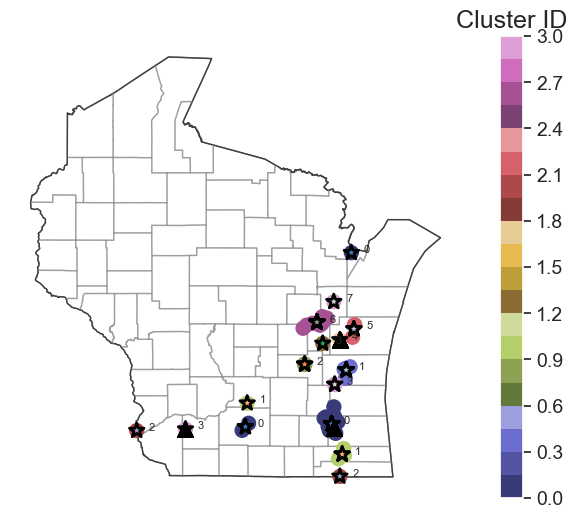

In [4]:
plot_well_centroid(bw_cluster_kmeans)

In [5]:
condensed_subcluster_bw_df = condense_subcluster_table(bw_cluster_kmeans)
condensed_subcluster_bw_df.head(5)

,state_alpha,cluster_id,subcluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,subcluster_centroid_dist,...,well_depth_ft,well_yield,total_well_yield,tds_kgm3,avg_TDS_kgm3,elec_price,well_field_lcow,avg_well_field_lcow,pipe_lcow,avg_subcluster_pipe_lcow
0,WI,0,0,44.064995,-87.880646,254.496216,45.065000,-87.693000,189.556702,112.184838,...,[492.0],[0.0151416479999999],0.015142,[1.4088665],1.408866,0.0731,[0.0761719163183517],0.076172,[0.0],0.000000
1,WI,0,1,44.064995,-87.880646,254.496216,43.719321,-87.777190,195.547623,39.321051,...,"[611.0, 115.0, 440.0, 460.0, 496.0, 1475.0, 36...","[0.0126180399999999, 0.0126180399999999, 0.010...",0.111291,"[1.84, 1.4, 0.546, 0.724, 0.516, 10.1, 0.844]",2.085178,0.0731,"[0.0867367455202759, 0.0460114682392675, 0.071...",0.082007,"[0.20594569787246794, 0.21651235666553947, 0.2...",0.214977
2,WI,0,2,44.064995,-87.880646,254.496216,43.784712,-88.449738,229.353683,55.214245,...,"[480.0, 650.0, 825.0]","[0.0229017425999999, 0.0488318148, 0.061512944...",0.133247,"[0.866, 0.528, 0.774]",0.699659,0.0731,"[0.0735611853091139, 0.0848925751472992, 0.098...",0.089452,"[0.11193607875931699, 0.07859883333844407, 0.0...",0.081647
3,WI,0,3,44.064995,-87.880646,254.496216,44.024158,-88.156769,279.061432,22.531940,...,[213.0],[0.013248942],0.013249,[0.749],0.749000,0.0731,[0.0533228050286567],0.053323,[0.0],0.000000
4,WI,0,4,44.064995,-87.880646,254.496216,44.064995,-87.880646,254.496216,0.000000,...,[626.0],[0.033122355],0.033122,[0.522],0.522000,0.0731,[0.0838759688056091],0.083876,[0.0],0.000000


In [6]:
condensed_cluster_bw_df = condense_cluster_table(condensed_subcluster_bw_df)
condensed_cluster_bw_df.head(5)

0 -> 7 -> 6 -> 3 -> 4 -> treatment_node
2 -> 3 -> 4 -> treatment_node
7 -> 6 -> 3 -> 4 -> treatment_node
1 -> 4 -> treatment_node
6 -> 3 -> 4 -> treatment_node
5 -> 4 -> treatment_node
3 -> 4 -> treatment_node
4 -> treatment_node

Node: 0
Nodes included 0

Node: 7
Nodes included 7
Nodes included 0

Node: 6
Nodes included 6
Nodes included 7
Node: 2
Nodes included 2

Node: 3
Nodes included 3
Nodes included 6
Nodes included 2
Node: 5
Nodes included 5
Node: 1
Nodes included 1

Node: 4
Nodes included 4
Nodes included 3
Nodes included 5
Nodes included 1
1 -> 0 -> 3 -> treatment_node
0 -> 3 -> treatment_node
2 -> 3 -> treatment_node
3 -> treatment_node

Node: 1
Nodes included 1

Node: 2
Nodes included 2
Node: 0
Nodes included 0
Nodes included 1

Node: 3
Nodes included 3
Nodes included 2
Nodes included 0
2 -> 1 -> 0 -> treatment_node
3 -> 0 -> treatment_node
1 -> 0 -> treatment_node
0 -> treatment_node

Node: 2
Nodes included 2

Node: 1
Nodes included 1
Nodes included 2
Node: 3
Nodes included 

,state_alpha,cluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,subcluster_centroid_dist,cluster_total_well_yield,cluster_avg_TDS_kgm3,elec_price,cluster_avg_well_field_lcow,cluster_avg_pipe_well_subcluster_lcow,cluster_avg_pipe_subcluster_cluster_lcow
0,WI,0,44.064995,-87.880646,254.496216,"[45.065, 43.71932111428571, 43.78471243333333,...","[-87.693, -87.77719007142858, -88.449737533333...","[189.55670166, 195.54762268099998, 229.3536834...","[112.18483770565331, 39.32105110754234, 55.214...",0.628631,1.164165,0.0731,0.083051,0.173226,0.160872
1,WI,1,43.041657,-90.379288,358.595764,"[43.06749725, 43.3391533, 43.0244293, 43.0416565]","[-89.40942385, -89.379837, -91.1690216, -90.37...","[260.221832275, 320.557312012, 188.130447388, ...","[78.85400614798243, 87.5178234627532, 64.21726...",0.231226,0.569633,0.0731,0.078095,0.079405,0.309349
2,WI,2,43.050015,-87.972031,216.597595,"[43.10073071363637, 42.75261179999999, 42.4989...","[-88.01297967727271, -87.84183756666665, -87.8...","[222.18171206422724, 214.674758911, 216.740951...","[6.54714482843398, 34.72843605607956, 61.74368...",1.065215,0.768248,0.0731,0.148776,0.171449,0.117489


In [7]:
condensed_cluster_bw_df = calc_cluster_lcow(condensed_cluster_bw_df,dist_to_dwi = 16.0934)
condensed_cluster_bw_df.head(5)


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

,state_alpha,cluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,subcluster_centroid_dist,cluster_total_well_yield,cluster_avg_TDS_kgm3,elec_price,cluster_avg_well_field_lcow,cluster_avg_pipe_well_subcluster_lcow,cluster_avg_pipe_subcluster_cluster_lcow,treatment_lcow,cluster_pipe_brine_lcow,recovery,cluster_lcow
0,WI,0,44.064995,-87.880646,254.496216,"[45.065, 43.71932111428571, 43.78471243333333,...","[-87.693, -87.77719007142858, -88.449737533333...","[189.55670166, 195.54762268099998, 229.3536834...","[112.18483770565331, 39.32105110754234, 55.214...",0.628631,1.164165,0.0731,0.090808,0.189404,0.175896,0.577266,0.023730,90.747161,1.057104
1,WI,1,43.041657,-90.379288,358.595764,"[43.06749725, 43.3391533, 43.0244293, 43.0416565]","[-89.40942385, -89.379837, -91.1690216, -90.37...","[260.221832275, 320.557312012, 188.130447388, ...","[78.85400614798243, 87.5178234627532, 64.21726...",0.231226,0.569633,0.0731,0.085388,0.086821,0.338240,0.609563,0.035552,92.444833,1.155564
2,WI,2,43.050015,-87.972031,216.597595,"[43.10073071363637, 42.75261179999999, 42.4989...","[-88.01297967727271, -87.84183756666665, -87.8...","[222.18171206422724, 214.674758911, 216.740951...","[6.54714482843398, 34.72843605607956, 61.74368...",1.065215,0.768248,0.0731,0.162670,0.187461,0.128461,0.541120,0.017639,91.458438,1.037352


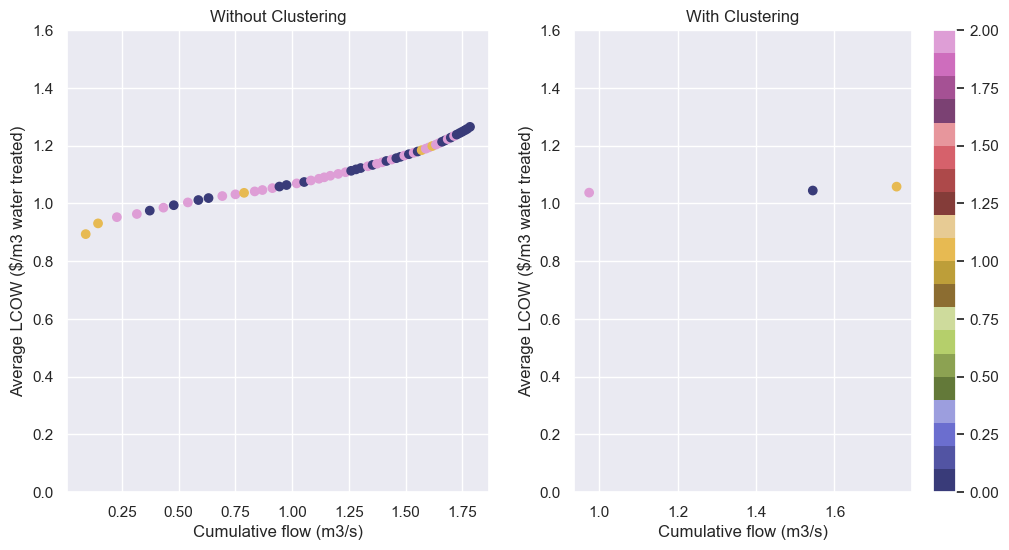

In [8]:
plot_supply_curve(bw_cluster_kmeans,condensed_cluster_bw_df,state_alpha)

In [9]:
# condensed_subcluster_bw_df.to_csv(r'\Users\mhardika\Documents\AMO\wi_subcluster_lcow_5Dec23.csv')
# condensed_cluster_bw_df.to_csv(r'\Users\mhardika\Documents\AMO\wi_cluster_lcow_5Dec23.csv')

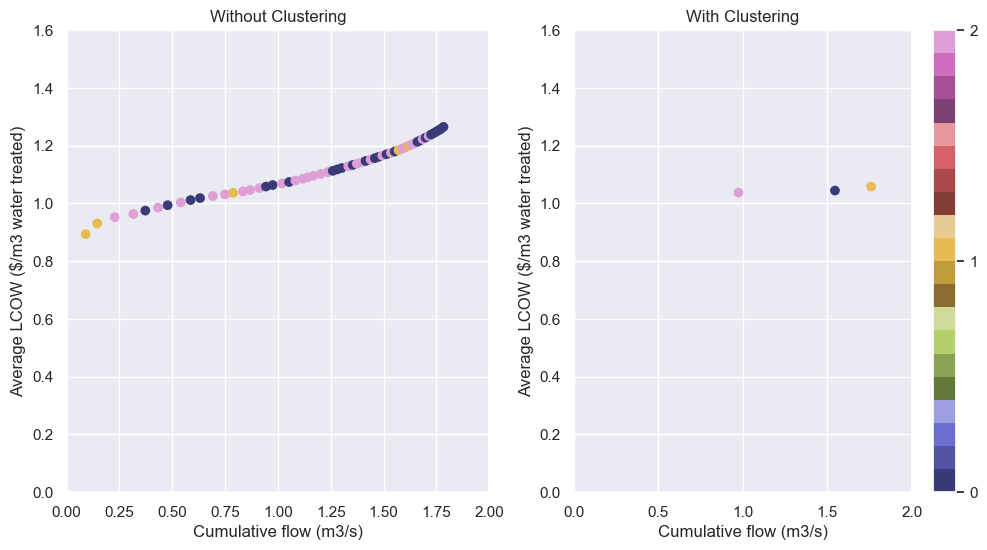

In [14]:
# # Plot supply curve with and without clustering
fig, (ax,ax1) = plt.subplots(1,2, figsize = (12,6))

# Without clustering
bw_df_temp_sorted_1 = bw_df[bw_df['state_alpha']==state_alpha].sort_values('lcow')
colors = plt.cm.get_cmap('tab20b')
cluster_id_list = []
for well in bw_df_temp_sorted_1['unique_site_ID'].unique():
    cluster_id_list.append(bw_cluster_kmeans[bw_cluster_kmeans['unique_site_ID']==well]['cluster_id'].values[0])

# Calculating LCOW as a function of well yield without clustering
flow = bw_df_temp_sorted_1['well_yield']*bw_df_temp_sorted_1['recovery']/100
cum_flow = flow.cumsum()

lcow_t = bw_df_temp_sorted_1['lcow'] + bw_df_temp_sorted_1['pipe_lcow']
cost = lcow_t*flow
cum_cost = cost.cumsum()

avg_lcow = np.divide(cum_cost, cum_flow, out=np.zeros_like(cum_cost), where=cum_flow!=0) 

ax.scatter(cum_flow,avg_lcow,c = cluster_id_list,cmap=colors)
ax.set_title('Without Clustering')

# With clustering
condensed_cluster_bw_df_sort = condensed_cluster_bw_df.sort_values(by=['cluster_lcow'])

flow = condensed_cluster_bw_df_sort['cluster_total_well_yield']*condensed_cluster_bw_df_sort['recovery']/100
cum_flow = flow.cumsum()

cost = condensed_cluster_bw_df_sort['cluster_lcow']*flow
cum_cost = cost.cumsum()

avg_lcow = np.divide(cum_cost, cum_flow) 

ax1.set_title('With Clustering')
sc = ax1.scatter(cum_flow,avg_lcow,c=condensed_cluster_bw_df_sort['cluster_id'].values,cmap=colors)
# cbar = plt.colorbar(sc,ax=ax1)
cbar = plt.colorbar(sc,ax=ax1,ticks = plt.MaxNLocator(len(condensed_cluster_bw_df_sort['cluster_id'].unique())-1))
for a in (ax,ax1):
    a.set_xlim([0,2])
    a.set_ylim([0,1.6])
    a.set_ylabel('Average LCOW ($/m3 water treated)')
    a.set_xlabel('Cumulative flow (m3/s)')

Below is rough work which was consolidated into bw_lcow_functions.py

In [36]:
# Read brackish water previous lcow file with locations

bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
pp_combined_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\MSD Workshop\data\pp_df.csv').drop(['Unnamed: 0'],axis=1)
loc = [Point(xy) for xy in zip(pp_combined_df['PPLongitude'],pp_combined_df['PPLatitude'])]
loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
pp_combined_df['geometry'] = loc

In [15]:
# Function to form clusters

def form_cluster(df,n_clusters = 3):
    kmeans = KMeans(n_clusters = n_clusters, init ='k-means++',random_state=42)
    kmeans.fit(df[df.columns[2:4]])  # Compute k-means clustering.
    df['cluster_id'] = kmeans.fit_predict(df[df.columns[2:4]])
    centers = kmeans.cluster_centers_  # Coordinates of cluster centers.
    labels = kmeans.predict(df[df.columns[2:4]])  # Labels of each point
    centers_array = []
    for idx,row in df.iterrows():
        centers_array.append(centers[int(row['cluster_id'])])
    df['centers'] = centers_array
    
    return df

In [24]:
# Create a table with cluster ID

bw_cluster_kmeans = pd.DataFrame()
bw_state_df = pd.DataFrame()
bw_state_df_loc = pd.DataFrame()

for state in ['CT']: #bw_df['state_alpha'].unique():
    # kmeans doesn't work for fewer than 3 points. Calculate centroid for these cases
    print('State:',state)
    bw_state_df = bw_df[bw_df['state_alpha'] == state].copy()
    bw_state_df_loc = bw_state_df[['state_alpha','unique_site_ID','Latitude','Longitude','county_nm','well_depth_ft','well_yield','TDS_kgm3','elec_price','well_field_lcow']]

    if len(bw_state_df)<=3:
        bw_state_df_loc['cluster_id'] = 0
        bw_state_df_loc['well_yield'] = bw_state_df['well_yield']
        bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,bw_state_df_loc])
        continue 

    # First pass at clustering for a state
    # bw_state_df_loc = bw_state_df[['unique_site_ID','Latitude','Longitude']].copy()
    bw_state_df_loc = form_cluster(bw_state_df_loc)

    # Assign well yield
    bw_state_df_loc['well_yield'] = bw_state_df['well_yield']
    bw_state_df_loc = bw_state_df_loc.sort_values(['cluster_id'])

    # print('Initial cluster list:',bw_state_df_loc['cluster_id'].unique())

    # To keep track of clusters and new created clusters if the maximum capacity of a treatment plant is exceeded
    prev_max_cluster_label = 0

    # Dataframe for each state with their respective cluster id
    cluster_state_df = pd.DataFrame()

    for cluster_id in bw_state_df_loc['cluster_id'].unique():
        cluster_sub_df = pd.DataFrame()
        temp_df = pd.DataFrame()
        # Check if maximum capacity of treatment plant is exceeded
        well_yield_total = sum(bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id]['well_yield'])

        max_capacity = math.ceil(27.5*0.043813)  #---> Number is based on Carlsbad. Kay Bailey is 27.5 MGD
        if well_yield_total > max_capacity: 
            # If exceed increase number of clusters in the original cluster and redo
            
            cluster_sub_df = bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id].copy()

            # print("Number of clusters required:", math.ceil(well_yield_total/max_capacity))
            temp_df = form_cluster( cluster_sub_df, n_clusters = math.ceil(well_yield_total/max_capacity))
            temp_df = temp_df.sort_values(['cluster_id'])
            if cluster_id == 0:
                temp_df['cluster_id'].update(prev_max_cluster_label + temp_df['cluster_id'])
            else:
                temp_df['cluster_id'].update(prev_max_cluster_label + temp_df['cluster_id'] + 1)
            prev_max_cluster_label = max(temp_df['cluster_id'])
            
            cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)
        else:
            # If maximum capacity is not exceeded add to state data frame
            temp_bw_state_df_loc = bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id].copy()
            if cluster_id == 0:
               temp_bw_state_df_loc['cluster_id'] = prev_max_cluster_label 
            else:
               temp_bw_state_df_loc['cluster_id'] = prev_max_cluster_label + 1

            cluster_state_df = pd.concat([cluster_state_df,temp_bw_state_df_loc],ignore_index=True)
            prev_max_cluster_label = max(cluster_state_df['cluster_id'])

        print(cluster_state_df['cluster_id'].unique())
    
    bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,cluster_state_df])

State: CT
[0]
[0 1]
[0 1 2]


In [17]:
# Function to find well closest to the center of the cluster
def select_centroid(df):
    max_dist = 1000
    # well = df['unique_site_ID'][0]

    for idx, row in df.iterrows():
        bw_long = row['Longitude']
        bw_lat = row['Latitude']

        bw_loc = (bw_lat,bw_long)

        cent_long = row['centers'][1]
        cent_lat = row['centers'][0]
        
        cent_loc = (cent_lat,cent_long)

        dist_km = hs.haversine(cent_loc,bw_loc)

        if dist_km < max_dist:
            max_dist = dist_km
            well = row['unique_site_ID']
    
    return well
        

In [18]:
# Create subclusters to calculate pipe transport costs

def find_centroid(coords,cluster_range = 5):
    kms_per_radian = 6371.0088
    range_km = cluster_range*1.609343502101154
    epsilon = range_km/ kms_per_radian

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    # get the number of clusters
    num_clusters = len(set(cluster_labels))

    # turn the clusters in to a pandas series, where each element is a cluster of points
    clusters = pd.Series((coords[cluster_labels==n] for n in range(num_clusters)))
    centroids = []

    for ea in clusters:
        centroids.append((MultiPoint(ea).centroid.x, MultiPoint(ea).centroid.y))

    centroids = np.array(centroids)
    return [centroids,cluster_labels]

def create_subcluster(state_df):
    sub_cluster_df = pd.DataFrame(columns = ['sub_cluster_id','centroid'])

    for cluster_id in state_df['cluster_id'].unique():
        
        coords_input = state_df[state_df['cluster_id']==cluster_id][['Latitude', 'Longitude']].to_numpy()
        centroids,cluster_labels = find_centroid(coords_input,10)

        loc = [Point(xy) for xy in zip(centroids[:,1],centroids[:,0])]
        loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
        loc.geometry = loc.geometry.to_crs('EPSG:4326')

        # Assign cluster label
        temp = pd.DataFrame(columns = ['sub_cluster_id','centroid'])
        # temp['cluster_id'] = 0
        temp['sub_cluster_id'] = cluster_labels
        temp['centroid'] = loc.geometry[cluster_labels].values

        sub_cluster_df= pd.concat([sub_cluster_df,temp])

    return [sub_cluster_df['sub_cluster_id'].values.tolist(), 
            sub_cluster_df['centroid'].values.x.tolist(), 
            sub_cluster_df['centroid'].values.y.tolist()]

# Groups wells within 25 miles of each other

In [25]:
# Assign elevation to each well field, calculate distance between cluster center and other well fields in the cluster

well_elevation_list = []
centroid_elevation_list = []
subcluster_elevation_list = []

centroid_long_list = []
centroid_lat_list = []
sub_cluster_id_list = []
sub_cluster_centroid_long_list = []
sub_cluster_centroid_lat_list = []
sub_cluster_dist_list = []

for state in bw_cluster_kmeans.state_alpha.unique():
    temp_state = bw_cluster_kmeans[bw_cluster_kmeans.state_alpha == state].copy()

    for cluster_id in temp_state.cluster_id.unique():
        temp_cluster = temp_state[temp_state.cluster_id==cluster_id].copy()
        centroid_well = select_centroid(temp_cluster)
        # print(centroid_well)

        centroid_long = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['Longitude'].values[0]
        centroid_lat = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['Latitude'].values[0]

        [sub_cluster_id,sub_cluster_centroid_long,sub_cluster_centroid_lat] = create_subcluster(temp_state)

        for well in temp_cluster['unique_site_ID'].unique():
            bw_long = temp_cluster[temp_cluster['unique_site_ID']==well]['Longitude'].values[0]
            bw_lat = temp_cluster[temp_cluster['unique_site_ID']==well]['Latitude'].values[0]

            well_elevation_list.append(elevation(bw_lat,bw_long))
            centroid_long_list.append(centroid_long)
            centroid_lat_list.append(centroid_lat) 
            centroid_elevation_list.append(elevation(centroid_lat,centroid_long))

    sub_cluster_id_list.extend(sub_cluster_id)
    sub_cluster_centroid_long_list.extend(sub_cluster_centroid_long)
    sub_cluster_centroid_lat_list.extend(sub_cluster_centroid_lat)

bw_cluster_kmeans['well_elevation'] = well_elevation_list
bw_cluster_kmeans['centroid_long'] = centroid_long_list
bw_cluster_kmeans['centroid_lat'] = centroid_lat_list
bw_cluster_kmeans['centroid_elevation'] = centroid_elevation_list
bw_cluster_kmeans['sub_cluster_id'] = sub_cluster_id_list
bw_cluster_kmeans['sub_cluster_long'] = sub_cluster_centroid_long_list
bw_cluster_kmeans['sub_cluster_lat'] = sub_cluster_centroid_lat_list

# Add distance between sub-cluster centroid and cluster centroid

for idx, row in bw_cluster_kmeans.iterrows():
    sub_cluster_loc = (row['sub_cluster_lat'],row['sub_cluster_long'])
    cent_loc = (row['centroid_lat'],row['centroid_long'])

    dist_km = hs.haversine(cent_loc,sub_cluster_loc)
    sub_cluster_dist_list.append(dist_km)

    subcluster_elevation_list.append(elevation(row['sub_cluster_lat'],row['sub_cluster_long']))

bw_cluster_kmeans['sub_cluster_to centroid_dist_km'] = sub_cluster_dist_list
bw_cluster_kmeans['subcluster_elevation'] = subcluster_elevation_list

bw_cluster_kmeans.head(20)

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,...,centers,well_elevation,centroid_long,centroid_lat,centroid_elevation,sub_cluster_id,sub_cluster_long,sub_cluster_lat,sub_cluster_to centroid_dist_km,subcluster_elevation
0,CT,USGS-413857072452901,41.649265,-72.757599,Hartford,300.0,0.011672,1.320000,0.1344,0.082106,...,"[41.66745950000001, -72.71912385]",15.849995,-72.680649,41.685654,40.811787,0,-72.719124,41.667460,3.782051,39.308598
1,CT,USGS-414108072405201,41.685654,-72.680649,Hartford,318.0,0.030283,1.240000,0.1344,0.082448,...,"[41.66745950000001, -72.71912385]",40.811787,-72.680649,41.685654,40.811787,0,-72.719124,41.667460,3.782051,39.308598
2,CT,USGS-410859073220001,41.149818,-73.366226,Fairfield,90.0,0.116401,2.430000,0.1344,0.045897,...,"[41.25759505, -73.39053344999999]",1.547440,-73.414841,41.365372,113.717278,0,-73.366226,41.149818,24.310519,1.547440
3,CT,USGS-412155073245501,41.365372,-73.414841,Fairfield,74.0,0.012618,0.506000,0.1344,0.047239,...,"[41.25759505, -73.39053344999999]",113.717278,-73.414841,41.365372,113.717278,1,-73.414841,41.365372,0.000000,113.717278
4,CT,USGS-411848072541901,41.313709,-72.904823,New Haven,63.0,0.034700,4.185004,0.1344,0.045485,...,"[41.3137093, -72.9048233]",2.780735,-72.904823,41.313709,2.780735,0,-72.904823,41.313709,0.000000,2.780735


In [12]:
# Add cost of pipe transport from well to the subcluster centroid
pipe_lcow_well_subcluster_list = []

for idx, row in bw_cluster_kmeans.iterrows():

    # Distance between subcluster centroid and well
    sub_cluster_loc = (row['sub_cluster_lat'],row['sub_cluster_long'])
    well_loc = (row['Latitude'],row['Longitude'])
    dist_km_well = hs.haversine(well_loc,sub_cluster_loc)

    # Elevation gain between subcluster centroid and well
    elev_gain = row['well_elevation'] - row['subcluster_elevation']

    if elev_gain<0:
        elev_gain = 1e-5    

    pipe_lcow_well_subcluster = pipe_costing(row['well_yield']*3600*24, dist_km_well,
                                             elev_gain=elev_gain,electricity_rate=row['elec_price'])
    
    pipe_lcow_well_subcluster_list.append(pipe_lcow_well_subcluster)

bw_cluster_kmeans['pipe_lcow_well_subcluster'] = pipe_lcow_well_subcluster_list


In [91]:
# Condense to subcluster level
calc_avg_tds = lambda x: np.average(x, weights=bw_cluster_kmeans.loc[x.index, "well_yield"])
calc_well_field_lcow = lambda x: np.average(x, weights=bw_cluster_kmeans.loc[x.index, "well_yield"])
calc_pipe_lcow = lambda x: np.average(x, weights=bw_cluster_kmeans.loc[x.index, "well_yield"])

cluster_df = pd.DataFrame()

# Condense to cluster level
for state in bw_cluster_kmeans['state_alpha'].unique():
    temp_df = bw_cluster_kmeans[bw_cluster_kmeans['state_alpha']==state]
    for cluster in temp_df['cluster_id'].unique():
        temp_cluster_df = temp_df[temp_df['cluster_id']==cluster]

        group_table  = temp_cluster_df.groupby(['state_alpha','cluster_id','sub_cluster_id']).agg(
                centroid_lat = ('centroid_lat','mean'),
                centroid_long = ('centroid_long','mean'),
                centroid_elev = ('centroid_elevation','mean'),

                subcluster_lat = ('sub_cluster_lat','mean'),
                subcluster_long = ('sub_cluster_long','mean'),
                subcluster_elev = ('subcluster_elevation','mean'),
                subcluster_centroid_dist = ('sub_cluster_to centroid_dist_km','mean'),

                unique_site_ID = ('unique_site_ID',','.join),
                well_lat = ('Latitude', pd.Series.to_list),
                well_long = ('Longitude',pd.Series.to_list),
                county_nm = ('county_nm',pd.Series.to_list),
                well_elevation = ('well_elevation',pd.Series.to_list),
                well_depth_ft = ('well_depth_ft', pd.Series.to_list),
                well_yield = ('well_yield',pd.Series.to_list),
                total_well_yield = ('well_yield','sum'),
                tds_kgm3 = ('TDS_kgm3',pd.Series.to_list),
                avg_TDS_kgm3 = ('TDS_kgm3', calc_avg_tds),
                elec_price = ('elec_price','mean'),
                well_field_lcow = ('well_field_lcow',pd.Series.to_list),
                avg_well_field_lcow = ('well_field_lcow',calc_well_field_lcow),
                pipe_lcow = ('pipe_lcow_well_subcluster', pd.Series.to_list),
                avg_subcluster_pipe_lcow = ('pipe_lcow_well_subcluster', calc_pipe_lcow),

               ).reset_index()

        cluster_df = pd.concat((cluster_df,group_table))
cluster_df.reset_index(inplace=True)
cluster_df.head(10)
# check


,index,state_alpha,cluster_id,sub_cluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,...,well_depth_ft,well_yield,total_well_yield,tds_kgm3,avg_TDS_kgm3,elec_price,well_field_lcow,avg_well_field_lcow,pipe_lcow,avg_subcluster_pipe_lcow
0,0,WI,0,0,44.064995,-87.880646,254.496216,45.065000,-87.693000,189.556702,...,[492.0],[0.0151416479999999],0.015142,[1.4088665],1.408866,0.0731,[0.0761719163183517],0.076172,[0.0],0.000000
1,1,WI,0,1,44.064995,-87.880646,254.496216,43.719321,-87.777190,195.547623,...,"[611.0, 115.0, 440.0, 460.0, 496.0, 1475.0, 36...","[0.0126180399999999, 0.0126180399999999, 0.010...",0.111291,"[1.84, 1.4, 0.546, 0.724, 0.516, 10.1, 0.844]",2.085178,0.0731,"[0.0867367455202759, 0.0460114682392675, 0.071...",0.082007,"[0.20594569787246794, 0.21651235666553947, 0.2...",0.214977
2,2,WI,0,2,44.064995,-87.880646,254.496216,43.784712,-88.449738,229.353683,...,"[480.0, 650.0, 825.0]","[0.0229017425999999, 0.0488318148, 0.061512944...",0.133247,"[0.866, 0.528, 0.774]",0.699659,0.0731,"[0.0735611853091139, 0.0848925751472992, 0.098...",0.089452,"[0.11193607875931699, 0.07859883333844407, 0.0...",0.081647
3,3,WI,0,3,44.064995,-87.880646,254.496216,44.024158,-88.156769,279.061432,...,[213.0],[0.013248942],0.013249,[0.749],0.749000,0.0731,[0.0533228050286567],0.053323,[0.0],0.000000
4,4,WI,0,4,44.064995,-87.880646,254.496216,44.064995,-87.880646,254.496216,...,[626.0],[0.033122355],0.033122,[0.522],0.522000,0.0731,[0.0838759688056091],0.083876,[0.0],0.000000
5,5,WI,0,5,44.064995,-87.880646,254.496216,44.189902,-87.651751,197.079514,...,"[107.0, 80.0, 600.0]","[0.0231541033999999, 0.01892706, 0.02208157]",0.064163,"[1.2, 0.684, 1.38]",1.109735,0.0731,"[0.0436382952412333, 0.0416113013912889, 0.084...",0.056934,"[0.2868584007140493, 0.21986043357405546, 0.20...",0.237849
6,6,WI,0,6,44.064995,-87.880646,254.496216,44.267438,-88.250362,221.394119,...,"[671.0, 1050.0, 475.0, 675.0, 525.0, 900.0, 57...","[0.0484532736, 0.0141952949999999, 0.033627076...",0.231856,"[0.882, 1.83, 0.768, 1.85, 1.02, 1.75, 1.3, 1.15]",1.173469,0.0731,"[0.0872562216189243, 0.1222661449485737, 0.072...",0.085777,"[0.2963667153776567, 0.26305910712319963, 0.27...",0.253735
7,7,WI,0,7,44.064995,-87.880646,254.496216,44.502769,-87.977882,183.408630,...,[973.0],[0.0265609741999999],0.026561,[0.554],0.554000,0.0731,[0.1123392677275063],0.112339,[0.0],0.000000
8,0,WI,1,0,43.041657,-90.379288,358.595764,43.067497,-89.409424,260.221832,...,"[730.0, 310.0]","[0.0977898099999999, 0.0583584349999999]",0.156148,"[0.537, 0.523]",0.531768,0.0731,"[0.0897763210293472, 0.057107592716079]",0.077567,"[0.10789877015633705, 0.1338127719961403]",0.117584
9,1,WI,1,1,43.041657,-90.379288,358.595764,43.339153,-89.379837,320.557312,...,[450.0],[0.04100863],0.041009,[0.746],0.746000,0.0731,[0.0695592304437109],0.069559,[0.0],0.000000


In [95]:
# Condense to cluster level
# Inline functions to calculate weighted average tds and lcows
calc_avg_tds = lambda x: np.average(x, weights=cluster_df.loc[x.index, "total_well_yield"])
calc_well_field_lcow = lambda x: np.average(x, weights=cluster_df.loc[x.index, "total_well_yield"])
calc_pipe_lcow = lambda x: np.average(x, weights=cluster_df.loc[x.index, "total_well_yield"])

cluster_bw_df = pd.DataFrame()
# Condense the table further to the cluster level
for cluster in cluster_df['cluster_id'].unique():
    temp_df = cluster_df[cluster_df['cluster_id'] == cluster]

    group_table  = temp_df.groupby(['state_alpha','cluster_id']).agg(
            centroid_lat = ('centroid_lat','mean'),
            centroid_long = ('centroid_long','mean'),
            centroid_elev = ('centroid_elev','mean'),

            subcluster_lat = ('subcluster_lat',pd.Series.to_list),
            subcluster_long = ('subcluster_long',pd.Series.to_list),
            subcluster_elev = ('subcluster_elev',pd.Series.to_list),
            subcluster_centroid_dist = ('subcluster_centroid_dist',pd.Series.to_list),

            cluster_total_well_yield = ('total_well_yield','sum'),
            cluster_avg_TDS_kgm3 = ('avg_TDS_kgm3', calc_avg_tds),
            elec_price = ('elec_price','mean'),
            cluster_avg_well_field_lcow = ('avg_well_field_lcow',calc_well_field_lcow),
            cluster_avg_pipe_lcow = ('avg_subcluster_pipe_lcow', calc_pipe_lcow),

        ).reset_index()

    cluster_bw_df = pd.concat((cluster_bw_df,group_table))

cluster_bw_df

,state_alpha,cluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,subcluster_centroid_dist,cluster_total_well_yield,cluster_avg_TDS_kgm3,elec_price,cluster_avg_well_field_lcow,cluster_avg_pipe_lcow
0,WI,0,44.064995,-87.880646,254.496216,"[45.065, 43.71932111428571, 43.78471243333333,...","[-87.693, -87.77719007142858, -88.449737533333...","[189.55670166, 195.54762268099998, 229.3536834...","[112.18483770565331, 39.32105110754234, 55.214...",0.628631,1.164165,0.0731,0.083051,0.173226
0,WI,1,43.041657,-90.379288,358.595764,"[43.06749725, 43.3391533, 43.0244293, 43.0416565]","[-89.40942385, -89.379837, -91.1690216, -90.37...","[260.221832275, 320.557312012, 188.130447388, ...","[78.85400614798243, 87.5178234627532, 64.21726...",0.231226,0.569633,0.0731,0.078095,0.079405
0,WI,2,43.050015,-87.972031,216.597595,"[43.10073071363637, 42.75261179999999, 42.4989...","[-88.01297967727271, -87.84183756666665, -87.8...","[222.130813599, 214.674758911, 216.740951538, ...","[6.54714482843398, 34.72843605607956, 61.74368...",1.065215,0.768248,0.0731,0.148776,0.171449


In [74]:
pipe_lcow_subcluster_centroid_list = []
for cluster in cluster_df['cluster_id'].unique()[0:1]:
    temp_df = cluster_df[cluster_df['cluster_id'] == cluster]
    for subcluster in temp_df['sub_cluster_id'].unique()[0:1]:
        print(temp_df[temp_df['sub_cluster_id']==subcluster]['subcluster_centroid_dist'].values[0])
        print(temp_df[temp_df['sub_cluster_id']==subcluster]['subcluster_elev'].values[0])
        print(temp_df[temp_df['sub_cluster_id']==subcluster]['centroid_elev'].values[0])
        print(temp_df[temp_df['sub_cluster_id']==subcluster]['total_well_yield'].values[0])
        pipe_costing()

112.18483770565331
189.55670166
254.49621582


In [26]:
# bw_cluster_kmeans.to_csv(r'\Users\mhardika\Documents\AMO\ct_kmeans_28Nov23.csv')

In [8]:
# Sort data in decreasing order of well yield
bw_cluster_kmeans_sorted = bw_cluster_kmeans.sort_values(['state_alpha','cluster_id','well_yield'],
                                                         ascending=[True,True,False]).groupby(['state_alpha','cluster_id']).apply(pd.DataFrame)
bw_cluster_kmeans_sorted.reset_index(inplace=True,drop=True)
bw_cluster_kmeans_sorted.head(2)

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,cluster_id,centers,well_elevation,centroid_long,centroid_lat,dist_km
0,TX,USGS-304805103013301,30.801289,-103.026184,Pecos,1975.0,0.277597,1.76,0.0545,0.150637,0,"[32.849717354166664, -101.76856669583333]",973.733643,-101.944,32.81,245.651724
1,TX,FETH-315940N1050840.1,31.994444,-105.144472,Hudspeth,154.0,0.184013,1.55,0.0545,0.039428,0,"[32.849717354166664, -101.76856669583333]",1114.347046,-101.944,32.81,313.840081


In [15]:
temp_state =  bw_cluster_kmeans_sorted[bw_cluster_kmeans_sorted.state_alpha == 'WI']
temp_cluster = temp_state[temp_state.cluster_id==0]
centroid_well = temp_cluster[temp_cluster['dist_km']==0]['unique_site_ID'].values[0]

temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['well_elevation'].values[0]


254.49621582

In [16]:
# Function to calculate LCOW

def treatment_only_LCOW(capacity,tds, well_depth, elec_price):
    case_study = 'big_spring'
    scenario = 'dwi_a'
    desired_recovery = 1
    ro_bounds = 'other' # or 'seawater'

    m = watertap_setup(case_study=case_study, scenario=scenario)
    m = get_case_study(m=m)
    m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

    m.fs.reverse_osmosis.membrane_area.unfix()
    m.fs.reverse_osmosis.feed.pressure.unfix()

    m.fs.big_spring_feed.flow_vol_in.fix(capacity) # capacity in m3s
    m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(tds) # tds in kg/m3
    m.fs.well_field.lift_height.fix(well_depth)

    m.fs.costing_param.electricity_price = elec_price 
    m = run_and_return_model(m, objective=True,print_it=True)
    m, df = get_results_table(m=m, case_study='test', scenario=scenario)    
    lcow = m.fs.costing.LCOW.value()
    well_field_lcow = m.fs.well_field.LCOW()
    recovery = m.fs.costing.system_recovery()*100
    # clear_output(wait=True)
    # print(well_field_lcow)
    # Exclude the well field LCOW from the cost ($/m3 avg well field flow), well lcow ($/m3 of only that well) and brine volume in m3/day
    return (lcow-well_field_lcow,recovery, m.fs.deep_well_injection.flow_vol_in[0].value*3600*24)

# treatment_only_LCOW(0.277597,1.760000,1975,0.0545)


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

(0.6067134031593403, 90.72529610288403, 2277.7398536529186)

In [17]:
# Calculate cumulative well yield, cumulative tds, lcow without well field, pipe lcow to treatment, brine lcow
bw_cluster_lcow = bw_cluster_kmeans_sorted.copy()

avg_well_yield_list = []
avg_tds_list = []
treatment_lcow_list = []
recovery_list = []
brine_vol_list = []
pipe_lcow_list = []
brine_lcow_list = []

dist_to_dwi = 16.0934 # = 10 miles

for state in bw_cluster_kmeans_sorted.state_alpha.unique():
    temp_state = bw_cluster_kmeans_sorted[bw_cluster_kmeans_sorted.state_alpha == state].copy()
    
    for cluster_id in temp_state.cluster_id.unique():
        temp_cluster = temp_state[temp_state.cluster_id==cluster_id].copy()
        avg_well_yield = 0
        avg_tds = 0
        
        centroid_well = temp_cluster[temp_cluster['dist_km']==0]['unique_site_ID'].values[0]
        centroid_elev = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['well_elevation'].values[0]
        print(centroid_elev)

        for well in temp_cluster['unique_site_ID'].unique():
            # Calculate average well yield
            avg_well_yield_old = avg_well_yield
            avg_well_yield = avg_well_yield + temp_cluster[temp_cluster['unique_site_ID']==well]['well_yield'].values[0]

            # Calculate average TDS
            avg_tds = ((avg_tds*avg_well_yield_old 
                       + temp_cluster[temp_cluster['unique_site_ID']==well]['TDS_kgm3'].values[0] *temp_cluster[temp_cluster['unique_site_ID']==well]['well_yield'].values[0])
                        /avg_well_yield)
            
            avg_well_yield_list.append(avg_well_yield)
            avg_tds_list.append(avg_tds)

            treatment_lcow, recovery, brine_flow = treatment_only_LCOW(avg_well_yield, avg_tds, 
                                                                  temp_cluster[temp_cluster['unique_site_ID']==well]['well_depth_ft'].values[0],
                                                                  temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])
            
            treatment_lcow_list.append(treatment_lcow)
            recovery_list.append(recovery)
            brine_vol_list.append(brine_flow)

            elev_gain = centroid_elev - temp_cluster['well_elevation'].values[0] 

            if elev_gain <= 0:
                elev_gain = 1e-5
            pipe_lcow = pipe_costing(avg_well_yield*3600*24, temp_cluster[temp_cluster['unique_site_ID']==well]['dist_km'].values[0], elev_gain = elev_gain,
                                      electricity_rate = temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])/(recovery/100)

            pipe_lcow_list.append(pipe_lcow)

            brine_transport_lcow = (pipe_costing(brine_flow, dist_to_dwi, elev_gain = 1e-5, 
                                                 electricity_rate = temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])
                                        *(100-recovery)/recovery)
            
            brine_lcow_list.append(brine_transport_lcow)
            
bw_cluster_lcow['avg_well_yield_m3/s'] = avg_well_yield_list
bw_cluster_lcow['avg_tds'] = avg_tds_list
bw_cluster_lcow['treatment_lcow'] = treatment_lcow_list
bw_cluster_lcow['recovery'] = recovery_list
bw_cluster_lcow['brine_vol_m3/day'] = brine_vol_list
bw_cluster_lcow['pipe_to_treatment_lcow'] = pipe_lcow_list
bw_cluster_lcow['brine_dwi_lcow'] = brine_lcow_list

bw_cluster_lcow.head(3)

921.343383789

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,...,centroid_long,centroid_lat,dist_km,avg_well_yield_m3/s,avg_tds,treatment_lcow,recovery,brine_vol_m3/day,pipe_to_treatment_lcow,brine_dwi_lcow
0,TX,USGS-304805103013301,30.801289,-103.026184,Pecos,1975.0,0.277597,1.76,0.0545,0.150637,...,-101.944,32.81,245.651724,0.277597,1.760000,0.606713,90.725296,2277.738828,1.293953,0.035684
1,TX,FETH-315940N1050840.1,31.994444,-105.144472,Hudspeth,154.0,0.184013,1.55,0.0545,0.039428,...,-101.944,32.81,313.840081,0.461610,1.676287,0.572683,90.332641,3943.844919,1.275404,0.028167
2,TX,USGS-304950103013401,30.830561,-103.025986,Pecos,425.0,0.157725,1.55,0.0545,0.056377,...,-101.944,32.81,242.681390,0.619335,1.644126,0.557073,90.307889,5304.620520,0.862420,0.024463


In [29]:
bw_cluster_lcow['cluster_lcow'] = bw_cluster_lcow['treatment_lcow'] + \
                bw_cluster_lcow['well_field_lcow']*bw_cluster_lcow['well_yield']/(bw_cluster_lcow['avg_well_yield_m3/s']*bw_cluster_lcow['recovery']/100) + \
                bw_cluster_lcow['brine_dwi_lcow'] +\
                bw_cluster_lcow['pipe_to_treatment_lcow']

In [30]:
bw_cluster_lcow_sorted = bw_cluster_lcow.sort_values(['state_alpha','cluster_id','cluster_lcow'],ascending=[True,True,True]).groupby(['state_alpha','cluster_id']).apply(pd.DataFrame)
bw_cluster_lcow_sorted.reset_index(inplace=True,drop=True)
bw_cluster_lcow.head(6)

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,...,centroid_lat,dist_km,avg_well_yield_m3/s,avg_tds,treatment_lcow,recovery,brine_vol_m3/day,pipe_to_treatment_lcow,brine_dwi_lcow,cluster_lcow
0,TX,USGS-304805103013301,30.801289,-103.026184,Pecos,1975.0,0.277597,1.760000,0.0545,0.150637,...,32.81,245.651724,0.277597,1.760000,0.606713,90.725296,2277.738828,1.293953,0.035684,2.102386
1,TX,FETH-315940N1050840.1,31.994444,-105.144472,Hudspeth,154.0,0.184013,1.550000,0.0545,0.039428,...,32.81,313.840081,0.461610,1.676287,0.572683,90.332641,3943.844919,1.275404,0.028167,1.893653
2,TX,USGS-304950103013401,30.830561,-103.025986,Pecos,425.0,0.157725,1.550000,0.0545,0.056377,...,32.81,242.681390,0.619335,1.644126,0.557073,90.307889,5304.620520,0.862420,0.024463,1.459853
3,TX,NURE-OR18965,35.506000,-101.036000,Gray,646.0,0.100944,1.160874,0.0545,0.070421,...,32.81,311.201453,0.720280,1.576400,0.548440,90.396882,6113.981176,1.012616,0.022651,1.594624
4,TX,FETH-311620N1033000.1,31.272222,-103.500028,Reeves,135.0,0.094635,6.210000,0.0545,0.041750,...,32.81,225.269531,0.814915,2.114495,0.557147,89.427146,7598.241324,0.711775,0.022822,1.297165
5,TX,NURE-OR11673,34.622000,-100.132000,Childress,125.0,0.075708,2.938153,0.0545,0.040378,...,32.81,262.065730,0.890623,2.184511,0.555191,89.284915,8413.302039,0.786655,0.022135,1.367825


In [20]:
# bw_cluster_lcow.to_csv(r'\Users\mhardika\Documents\AMO\tx_kmeans_lcow_8Nov23.csv')

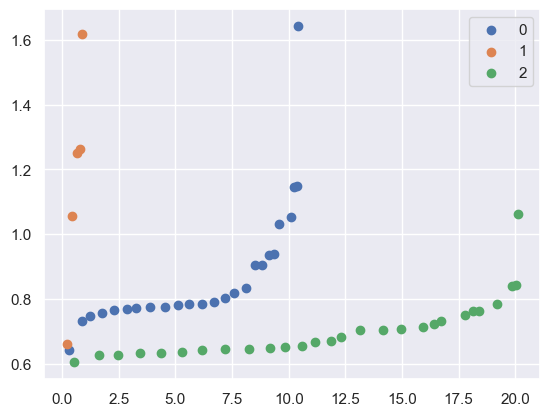

In [31]:
fig, ax = plt.subplots()

state_cluster_lcow = bw_cluster_lcow_sorted[bw_cluster_lcow_sorted['state_alpha']=='WI']

for cluster in state_cluster_lcow['cluster_id'].unique():
    temp = state_cluster_lcow[state_cluster_lcow['cluster_id']==cluster]
    ax.scatter(temp['avg_well_yield_m3/s'].cumsum(),temp['cluster_lcow'],label = cluster)

ax.legend()

(0.0, 2.0)

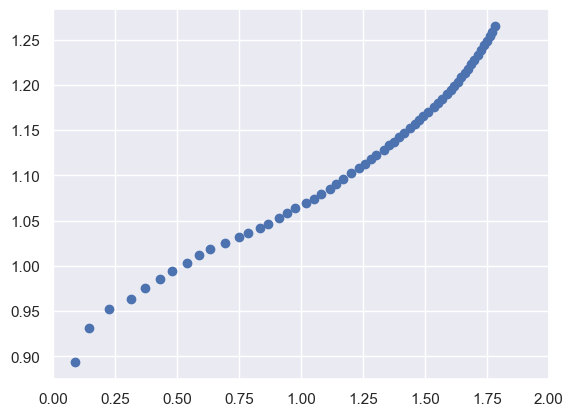

In [20]:
bw_df_temp_sorted_1 = bw_df[bw_df['state_alpha']=='WI'].sort_values('lcow')

lcow = 0
total_water = 0

fig, ax = plt.subplots()

# Calculating LCOW as a function of well yield without clustering
flow = bw_df_temp_sorted_1['well_yield']*bw_df_temp_sorted_1['recovery']/100
cum_flow = flow.cumsum()

lcow_t = bw_df_temp_sorted_1['lcow'] + bw_df_temp_sorted_1['pipe_lcow']
cost = lcow_t*flow
cum_cost = cost.cumsum()

avg_lcow = np.divide(cum_cost, cum_flow, out=np.zeros_like(cum_cost), where=cum_flow!=0) 

ax.scatter(cum_flow,avg_lcow)
ax.set_xlim([0,2])

In [19]:
wacc = 0.05
plant_lifetime_yrs =30
capital_recovery_factor = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
capital_recovery_factor

0.06505143508027657